In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from matplotlib.patches import Ellipse

sys.path.insert(0, '/home/aew492/CFE_gradients/code')

import load_tools

In [21]:
data_dir = '/scratch/aew492/CFE_gradients_output'

In [22]:
# which mock parameters to use
L = 1000
n = '2e-4'
cat_tag = f'L{L}_n{n}_z057_patchy_As2x'

m = 1
b = 0.5

grad_dim = 2

In [23]:
# load amplitudes
cfe_amps = load_tools.load_suave_amps(cat_tag, grad_dim=grad_dim, m=m, b=b)

In [64]:
# input gradient vector
mock_dict = np.load(os.path.join(data_dir, f'gradient/{grad_dim}D/mock_data/{cat_tag}/{cat_tag}_rlz0_m-{m:.3f}-L_b-{b:0.3f}.npy'), allow_pickle=True).item()
grad_input = mock_dict['grad_expected']

### slice of one realization

In [65]:
mock_data = mock_dict['grad_set']
w_hat = mock_dict['w_hat']
boxsize = mock_dict['boxsize']

(200452, 3)

In [71]:
# xy-slice for plotting
z_max = -300
data_slice = mock_data[np.where(mock_data[:,2] < z_max)]

In [72]:
# plotting w_hat
def arrow(gradient):
    cent = [0,0]
    base = cent-gradient[:2]/2
    head = cent+gradient[:2]/2
    return base, head

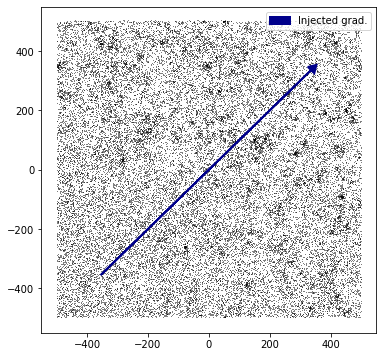

In [77]:
fig, ax = plt.subplots(figsize=(6,6))

L = boxsize
color = 'darkblue'
lw = 2
A = 0.1

ax.plot(data_slice[:,0], data_slice[:,1], 'k,', alpha=0.5)
# ax.set_title(r'$\omega_{input}$'+' = [ {:.2f},  {:.2f},  {:.2f} ]'.format(w_hat[0], w_hat[1], w_hat[2]))

# plot w_hat arrow
base, head = arrow(w_hat)
b = np.linalg.norm(head-base)
ax.arrow(L*base[0], L*base[1], 2*L*head[0], 2*L*head[1], color=color, lw=lw,
         head_width=0.3*A*L*b, head_length=0.25*A*L*b, length_includes_head=True, zorder=100, label='Injected grad.')
ax.legend()

### histograms of gradient amplitudes

In [14]:
# "raw" amplitudes first
a0, ax, ay, az = cfe_amps.T

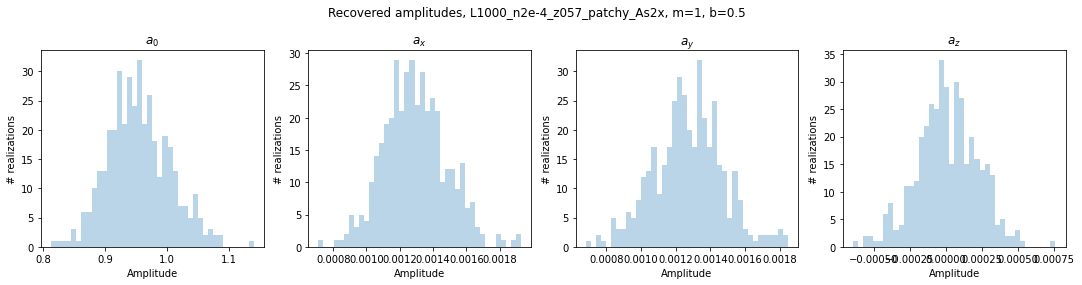

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(15,4))

labels = ['$a_0$', '$a_x$', '$a_y$', '$a_z$']

for i, amp in enumerate(cfe_amps.T):
    axs[i].hist(amp, bins=40, histtype='stepfilled', alpha=0.3)
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('# realizations')
    axs[i].set_title(labels[i])

fig.suptitle(f'Recovered amplitudes, {cat_tag}, m={m}, b={b}')
fig.tight_layout()

In [47]:
# recovered gradient vectors
grads_rec = np.array([amp[1:]/amp[0] for amp in cfe_amps])

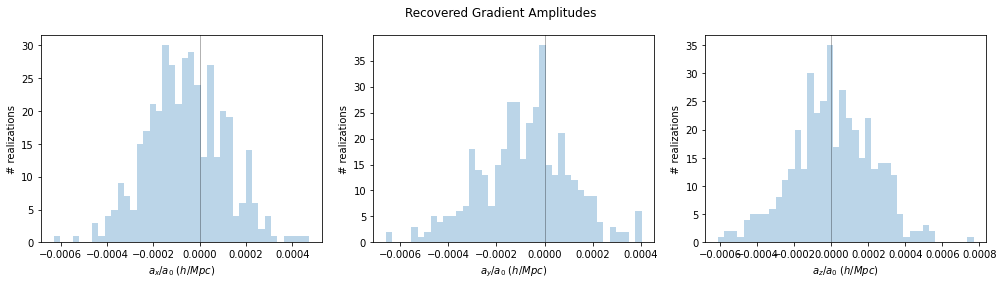

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))

labels = ['$a_x/a_0$', '$a_y/a_0$', '$a_z/a_0$']

for i, comp in enumerate(grads_rec.T):
    axs[i].hist(comp-grad_input[i], bins=40, histtype='stepfilled', alpha=0.3)
    axs[i].set_xlabel(f'{labels[i]} ($h/Mpc$)')
    axs[i].set_ylabel('# realizations')
    axs[i].axvline(0, color='k', alpha=0.3, lw=1)

fig.suptitle('Recovered Gradient Amplitudes')
fig.tight_layout()

### 2D distribution

In [37]:
# median recovered gradient, to center ellipse
grad_rec_median = np.median(grads_rec, axis=0)

In [39]:
# standard deviations
stds = np.std(grads_rec, axis=0)

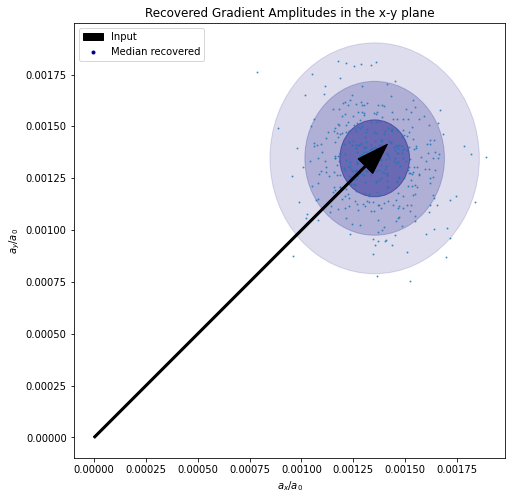

In [59]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(grads_rec[:,0], grads_rec[:,1], marker='.', markersize=2, ls='None', alpha=0.7)
ax.arrow(0,0,grad_input[0], grad_input[1], color='k', length_includes_head=True, width=0.00001, head_width=0.0001, label='Input', zorder=100)
ax.scatter(grad_rec_median[0], grad_rec_median[1], color='navy', marker='.', label='Median recovered')
for i in range(1,4):
    ellipse = Ellipse(xy=(grad_rec_median[0], grad_rec_median[1]), width=i*2*stds[0], height=i*2*stds[1], color='navy', fill=True, alpha=0.4/i)
    ax.add_patch(ellipse)

ax.set_aspect('equal')
ax.set_xlabel(r'$a_x / a_0$')
ax.set_ylabel(r'$a_y / a_0$')
ax.set_title(f'Recovered Gradient Amplitudes in the x-y plane')
plt.legend()